In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import pickle
import zipfile
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from matplotlib import pyplot as plt

Import the dataSet

In [ ]:
data_import = pd.read_csv('/content/drive/MyDrive/DataSet/male_players.csv')


Data preprocessing

This row descibe the dataset

In [ ]:
def data_preprocessing(input_data):
  #In this row, i will be dropping columns with more than 30% missing values for the numerical features.
  data_import = data_import.dropna(thresh=0.3*len(data_import), axis=1, inplace=True)

  numerical_features = data_import.select_dtypes(include=['int64', 'float64'])
  categorical_features = data_import.select_dtypes(include=['object'])

  # Drop columns with more 90% unique values
  predominantly = [col for col in categorical_features.columns if categorical_features[col].nunique() >= 0.9 * len(categorical_features)]
  categorical_features = categorical_features.drop(predominantly, axis=1, inplace=True )

  categorical_features = categorical_features.drop(['dob', 'club_joined_date', 'player_url', 'player_face_url'], axis=1)

  encodings_map  = {}

  for col in categorical_features.select_dtypes(include=['object']).columns:
      encoded_values, unique_categories = pd.factorize(categorical_features[col])
      encodings_map[col] = dict(zip(unique_categories, encoded_values))
      categorical_features[col] = encoded_values

      #I will combine the numerical and categorical features to form one dataframe that will be used for training the model
      data_import1 = pd.concat([numerical_features, categorical_features], axis=1)
  return data_import1, encodings_map

In [ ]:
X = data_import.drop(['overall'], axis=1)
y = data_import['overall']
X_imputed = X.fillna(X.mean())
y_imputed = y

Here i will be imputing the missing values in the dataset by filling them with the mean of the column if any dataset is nana or -

I will be training the data with the random forest regressor with a 100 estimators.

In [ ]:
imputedRegressor = RandomForestRegressor(n_estimators=100, random_state=42)

imputedRegressor.fit(X_imputed, y_imputed)

RandomForestRegressor(random_state=42)

4.Measure the model's performance and fine-tune it as a process of optimization.

RandomForestRegressor(random_state=42)

Since,i have started training this model, i wanted you, please rerun this cell in a Jupyter environment to show the trust of goodle colab.

I wanted to let the model choose for it the most important features in a dataframe format.

In [ ]:
'''imputed_feature_importances = pd.DataFrame(imputedRegressor.feature_importances_, index=X_imputed.columns, columns=['importance']).sort_values('importance', ascending=False)
imputed_feature_importances *= 100
imputed_feature_importances.head()
'''

I will be keeping only the important features for our X as the Independent Variables.

I will be checking to see how the data is distributed using X.describe().

In [ ]:
'''y = y_imputed

X = imputed_feature_importances[imputed_feature_importances['importance'] > 1].index
X = X_imputed[X]
X.head()'''

I will be scaling the data using the StandardScaler, and also, i will use it later

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

with open('scaler_model.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [ ]:
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X.describe()

,value_eur,categorial Age,age,potential,long_name,movement_reactions
count,1.615830e+05,1.615830e+05,1.615830e+05,1.615830e+05,1.615830e+05,1.615830e+05
mean,2.814327e-17,-2.420321e-16,8.442980e-17,-5.516080e-16,-6.754384e-17,2.532894e-16
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-3.897425e-01,-2.361605e+00,-1.953491e+00,-4.911888e+00,-1.444109e+00,-4.533988e+00
25%,-3.354480e-01,-6.502477e-01,-8.828718e-01,-7.579375e-01,-8.782299e-01,-7.172082e-01
50%,-2.642283e-01,-7.979525e-02,-2.637606e-02,-1.188681e-01,-1.181536e-01,4.614767e-02
75%,-7.151624e-02,6.808080e-01,6.159957e-01,6.799685e-01,7.742663e-01,7.004527e-01
max,3.211978e+01,4.864126e+00,6.183218e+00,3.875315e+00,2.288563e+00,3.753876e+00


I will be splitting the data for training and testing using the train_test_split function from sklearn.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((129266, 6), (129266,), (32317, 6), (32317,))

I will be training the models with 4 different regression models and comparing their performance

In [ ]:
most_models = {
    'RandomForestRegressor': RandomForestRegressor(n_estimators=5, random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'XGBRegressor': XGBRegressor()
}

mse = {}
mae = {}
r2 = {}

for name, model in most_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse[name] = mean_squared_error(y_test, y_pred)
    mae[name] = mean_absolute_error(y_test, y_pred)
    r2[name] = r2_score(y_test, y_pred)

Notes: The hard or softing will not be used here because; Two probabilistic classifiers trained using LogisticRegression and RandomForestClassifier is trained on Sklearn breast cancer dataset. RandomizedSearchCV is used for tuning both the LogisticRegression and RandomForestClassifier model Pipeline is used to create estimators for both the algorithms. Both hard and soft VotingClassifier is used for illustration purpose.

I will be converting perfomance data into a dataframe and sorting the data using the R2 score metric.

In [ ]:
accuracy = pd.DataFrame([mse, mae, r2], index=['MSE', 'MAE', 'R2']).T
accuracy = accuracy.sort_values('R2', ascending=False)
accuracy

,MSE,MAE,R2
RandomForestRegressor,0.312893,0.293913,0.993687
XGBRegressor,0.407757,0.455284,0.991773
GradientBoostingRegressor,0.947408,0.740731,0.980885
AdaBoostRegressor,4.054802,1.658361,0.918190


I will plot a graph that will be showing the accuracy data

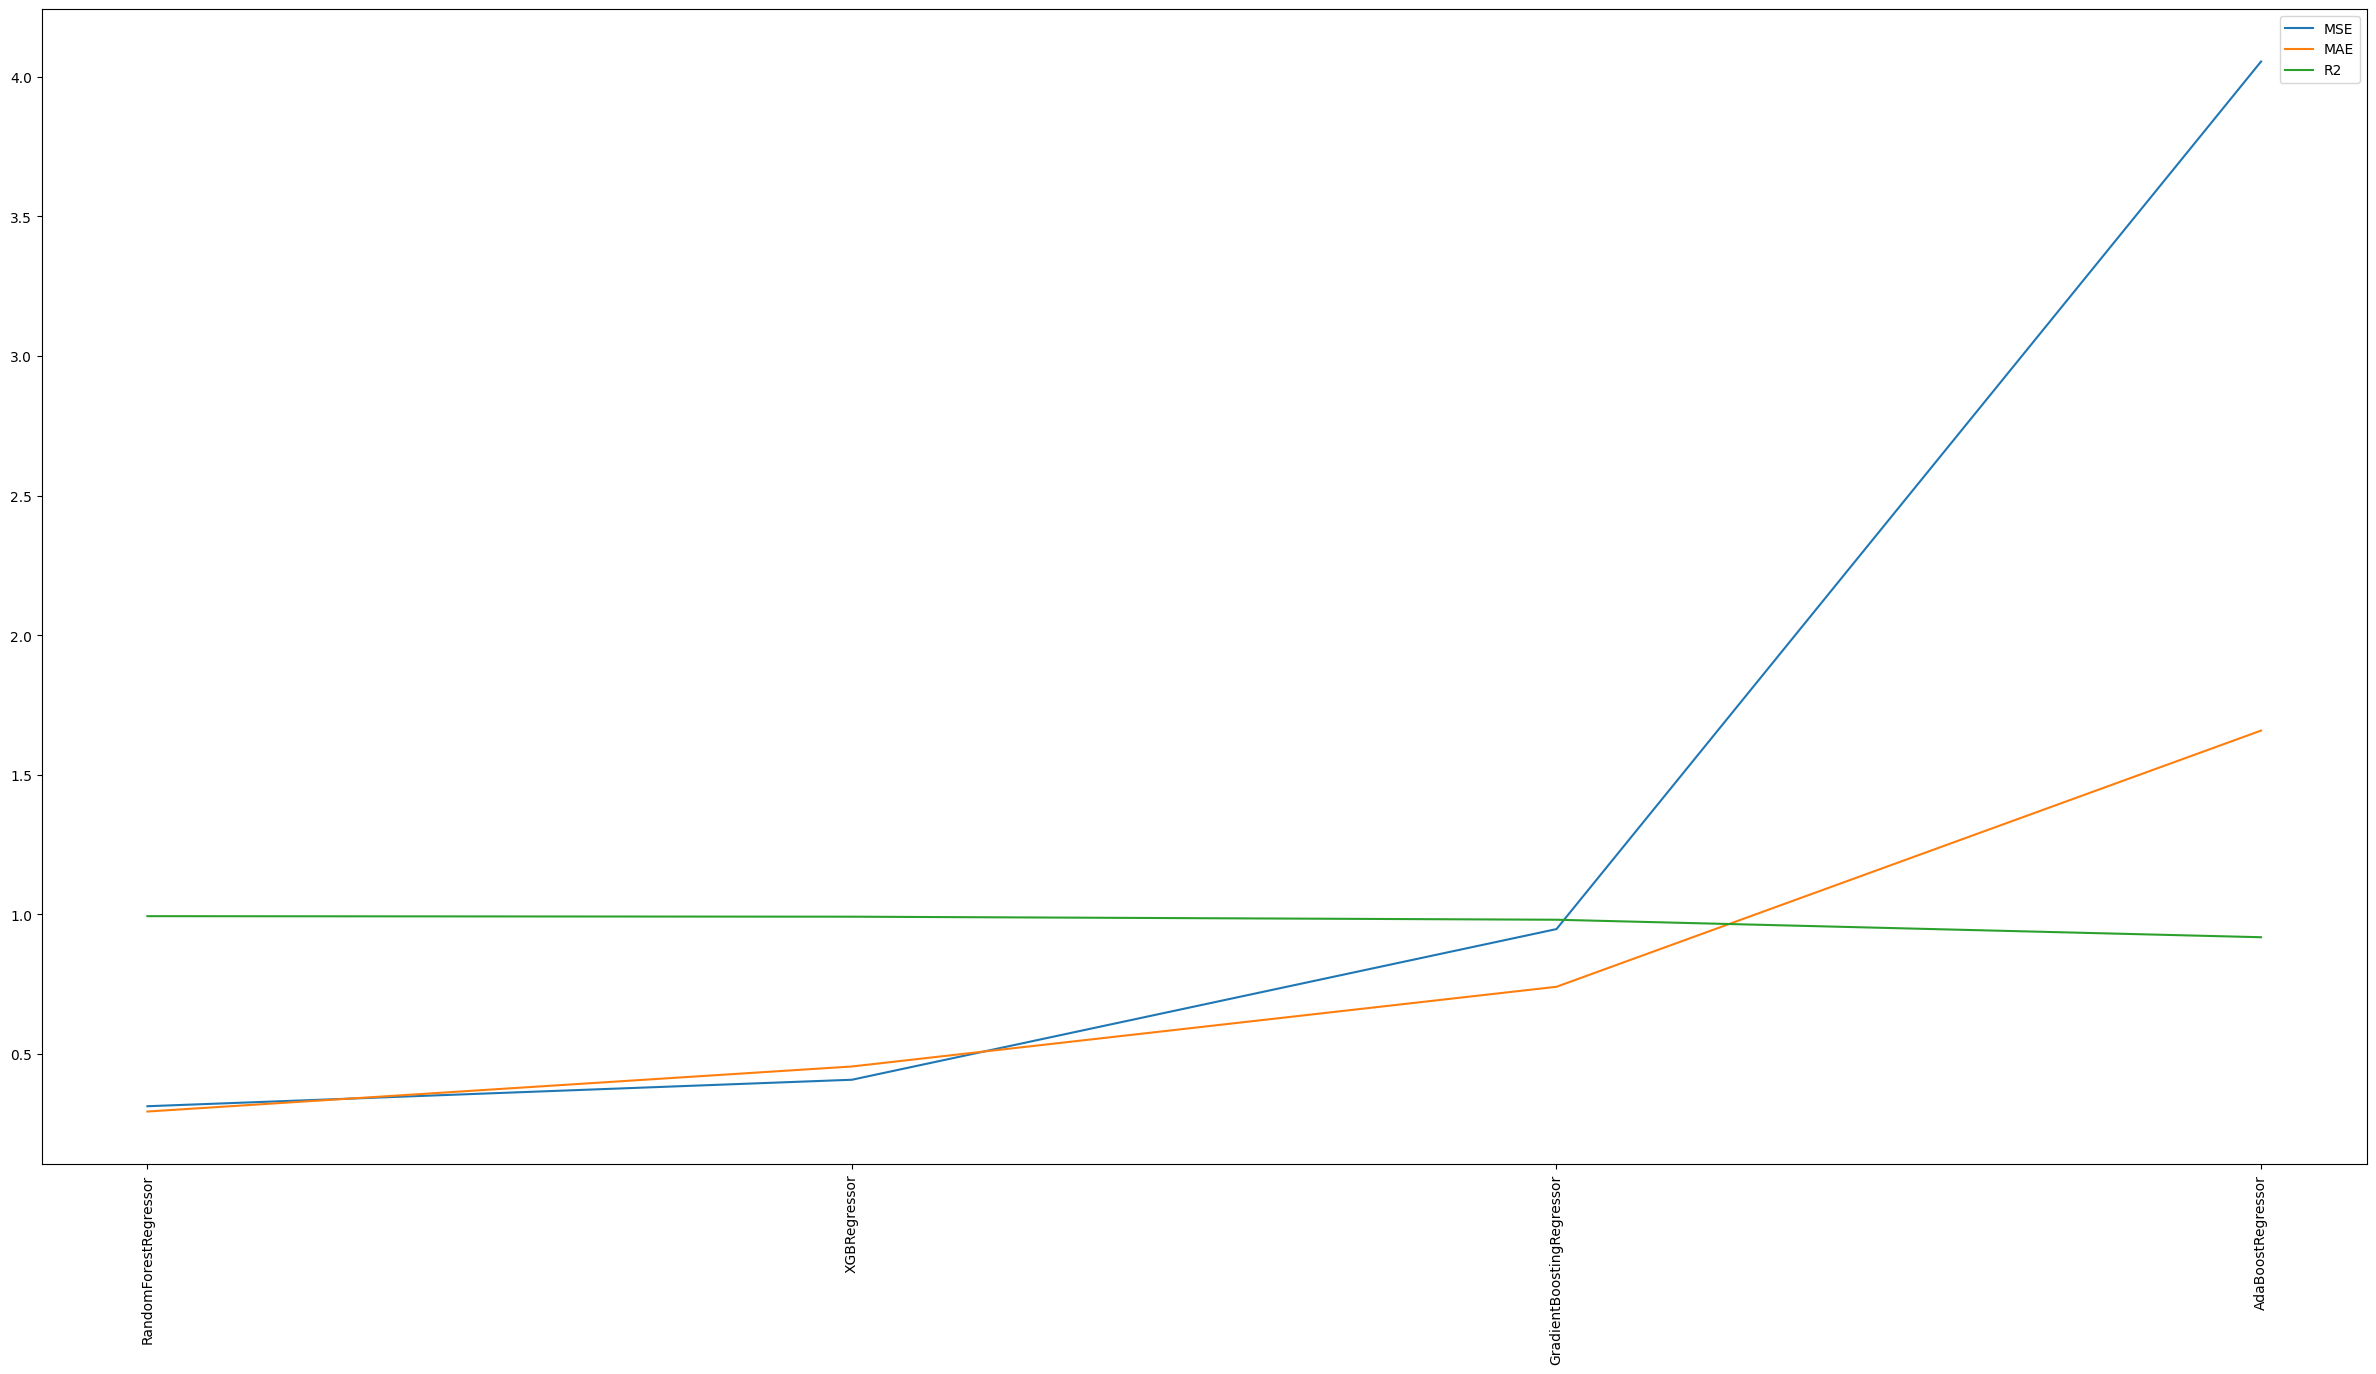

In [ ]:
plt.figure(figsize=(30, 15))
plt.plot(accuracy['MSE'], label='MSE')
plt.plot(accuracy['MAE'], label='MAE')
plt.plot(accuracy['R2'], label='R2')
plt.xticks(rotation=90)
plt.legend()
plt.show()

Random forest has the lowest mean absolute error of 0.29 and the highest r2 score of 0.99 so i wil go with the Random Forest Regressor algotithm..

This row below, i will focus on the hyperparameters of the model to get the best performance, and then, i will train it on the entire training dataset

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)

# Combine x_train and x_test into one data frame since its all part of the training set, applying the same to y

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

grid_search.fit(X, y)

grid_search.best_params_

Below will act as a starting point for training the model using the best parameters and the entire training dataset.

5. Use the data from another season(players_22) which was not used during the training to test how good is the model

In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.



Import Testing_dataset from a csv file and storing it in a dataframe.

# importing the data


In [ ]:
import pandas as pd
import pickle
import zipfile
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import pandas as pd
test_data_import = pd.read_csv('/players_22.csv')


In [ ]:
test_data_import.head(2)

Calculating the current age of the players in the testing dataset. This corresponds to the cat_age feature in the training dataset.

In [ ]:
test_data_import['categorialAge'] = 2024 - pd.to_datetime(test_data_import.dob).dt.year
test_data_import.categorialAge.head(1)

In this cell below, i will create a subset of the data that contains only the columns that were used to train the model.



In [ ]:
columns_Satisfied = ['value_eur','categorialAge','age','potential','movement_reactions']
test_features = test_data_import[columns_Satisfied]
test_features.head(2)

I wanted to see the information of selected features

In [ ]:
test_features.info()

In [ ]:
test_overall = test_data_import.overall
test_overall.head(2)

With a selected features,this cell below be will imputing the missing values in the dataset by filling them with the mean of the column

In [ ]:
test_features = test_features.fillna(test_features.mean())

In [ ]:
test_features.head()

I said before that i will later be using the StandardScaler object.

In [ ]:
with open('scaler_model.pkl', 'rb') as file:
    loaded_scaler = pickle.load(file)
test_features = loaded_scaler.transform(test_features)

The prediction will the overall rating of the players in the testing dataset.

In [ ]:
y_pred = model_with_best_params.predict(test_features)

Still, i will use the metrics of the model for printing values



In [ ]:
mae = mean_absolute_error(test_overall, y_pred)
r2 = r2_score(test_overall, y_pred)
mse = mean_squared_error(test_overall, y_pred)

print(f'MAE: {mae}')
print(f'R2: {r2}')
print(f'MSE: {mse}')

At this place, i will be plotting the actual against predicted values to see the correlation



In [ ]:
plt.figure(figsize=(35, 15))
plt.plot(test_overall, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Player')
plt.ylabel('Overall')
plt.legend()
plt.show()

Comparing the actual and predicated data


In [ ]:
comparison = pd.DataFrame({'Actual': test_overall, 'Predicted': y_pred})
comparison.tail(5)

You have seen the model has an r2 score of 0.978 which is very good, and the mean absolute error is 0.69 which is also very good.

6. Deploy the model on a simple web page using either (Heroku, Streamlite, or Flask) and upload a video that shows how the model performs on the web page/site
Now, i will be saving the model for deployment to the web app using pickle.

In [ ]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model_with_best_params, f)

The raw model is very large (more than 300mb in size) so we will compress it using gzip to make it smaller (less than 100mb) in size. This will allow us to upload it to github.

In [ ]:
zip_filename = "model.zip"
model_filename = "model.pkl"

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as archive:
    archive.write(model_filename)

print(f"{model_filename} has been zipped to {zip_filename}")

In this cell below, i will be removing the raw model to save space.

In [ ]:
file_path = 'model.pkl'

if os.path.exists(file_path):
    os.remove(file_path)
    print(f"{file_path} has been removed")